In [1]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

# Uncovering World Events using Twitter Hashtags

## ... and learning about Spark `DataFrames` along the way

In this notebook, we will use temporal information about Twitter hashtags to discover trending topics and potentially uncover world events as they occurred. You've already used this dataset in a previous homework, but here we will be working with it in Apache Spark.

### Hashtags

The idea here is that when an event is happening and people are having a conversation about it on Twitter, a set of uniform hashtags that represent the event spontaneously evolves. Twitter users then use those hashtags to communicate with one another. Some hashtags, like `#RT` for "retweet" or just `#retweet` are used frequently and don't tell us much about what is going on. But a sudden appearance of a hashtag like `#oscars` probably indicates that the oscars are underway. For a particularly cool example of this type of analysis, check out [this blog post about earthquake detection using Twitter data](https://blog.twitter.com/official/en_us/a/2015/usgs-twitter-data-earthquake-detection.html) (although they search the text and not necessarily hashtags).

## Initialize the `SparkSession`

In [2]:
import getpass
import pyspark
from pyspark.sql import SparkSession

conf = pyspark.conf.SparkConf()
conf.setMaster('yarn')
conf.setAppName('twitter-{0}'.format(getpass.getuser()))
conf.set('spark.executor.memory', '4g')
conf.set('spark.executor.instances', '6')
conf.set('spark.port.maxRetries', '100')
sc = pyspark.SparkContext.getOrCreate(conf)
conf = sc.getConf()
sc

<SparkContext master=yarn appName=twitter-baetu>

In [3]:
spark = SparkSession(sc)

## Set up the hashtag `DataFrame` (10 points / 60)

We have prepared the hashtag data spanning the time from April-July 2016. This is a significant time in modern European history, e.g. see [Brexit](https://en.wikipedia.org/wiki/Brexit). Lets see if we can see any interesting trends about these events in the Twitter data. 

In [4]:
from datetime import datetime

import pyspark.sql.functions as functions

### TODO (1 point/10)

Load the **parquet** data from `/datasets/twitter_hashtags` into a Spark dataframe using the appropriate `SparkSession` method. 

Look at the first few rows of the dataset - note the timestamp and its units!

In [5]:
df = spark.read.parquet('/datasets/twitter_hashtags')

In [6]:
df.show()

+-------------+----+-------------+
| timestamp_ms|lang|      hashtag|
+-------------+----+-------------+
|1459492860657| und|   2896Nation|
|1459492860657| und|     Republik|
|1459492860658|  en|          win|
|1459492860658|  en|  competition|
|1459492860658|  en|     giveaway|
|1459492860664|  tl| ALDUBYayaWho|
|1459492860663|  th|        ไคตัล|
|1459492860660|  es|      muybien|
|1459492860660|  th|    FLY2NDWIN|
|1459492860665|  en|      5SOSFam|
|1459492860665|  en|  BestFanArmy|
|1459492860665|  en| iHeartAwards|
|1459492861661|  ja|      hempire|
|1459492861657|  th|        ไคตัล|
|1459492861657|  es|    Venezuela|
|1459492861657|  es|   cristianos|
|1459492861660| und|         RUSH|
|1459492861660| und|        TFBJP|
|1459492861660| und|       TFBANG|
|1459492861661|  en|BirdieSanders|
+-------------+----+-------------+
only showing top 20 rows



We can observe that the *timestamp* is expressed in milliseconds since January 1$^{st}$ 1970.

### User-defined functions

A neat trick of spark dataframes is that you can essentially use something very much like an RDD `map` method but without switching to the RDD. If you are familiar with database languages, this works very much like e.g. a user-defined function in SQL. 

So, for example, if we wanted to make a user-defined python function that returns the hashtags in lowercase, we could do something like this:

In [7]:
@functions.udf
def lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

The @functions.udf is a "decorator" -- this is really handy python syntactic sugar and in this case is equivalent to:

```
def lowercase(text):
    return text.lower()
    
lowercase = functions.udf(lowercase)
```

It basically takes our function and adds to its functionality. In this case, it registers our function as a pyspark dataframe user-defined function (UDF).

Using these UDFs is very straightforward and analogous to other Spark dataframe operations. For example:

In [8]:
df.select(lowercase(df.hashtag)).show()

+------------------+
|lowercase(hashtag)|
+------------------+
|        2896nation|
|          republik|
|               win|
|       competition|
|          giveaway|
|      aldubyayawho|
|             ไคตัล|
|           muybien|
|         fly2ndwin|
|           5sosfam|
|       bestfanarmy|
|      iheartawards|
|           hempire|
|             ไคตัล|
|         venezuela|
|        cristianos|
|              rush|
|             tfbjp|
|            tfbang|
|     birdiesanders|
+------------------+
only showing top 20 rows



Using a framework like Spark is all about understanding the ins and outs of how it functions and knowing what it offers. One of the cool things about the dataframe API is that many functions are already defined for you (turning strings into lowercase being one of them). 

### TODO (2 points / 10)

Find the Spark python API documentation. Look for the `sql` section and find the listing of `sql.functions`. Repeat the above (turning hashtags into lowercase) but use the built-in function.

In [9]:
df.select(functions.lower(df.hashtag)).show()

+--------------+
|lower(hashtag)|
+--------------+
|    2896nation|
|      republik|
|           win|
|   competition|
|      giveaway|
|  aldubyayawho|
|         ไคตัล|
|       muybien|
|     fly2ndwin|
|       5sosfam|
|   bestfanarmy|
|  iheartawards|
|       hempire|
|         ไคตัล|
|     venezuela|
|    cristianos|
|          rush|
|         tfbjp|
|        tfbang|
| birdiesanders|
+--------------+
only showing top 20 rows



We'll work with a combination of these built-in functions and user-defined functions for the remainder of this homework. 

### TODO (7 points/10)

Create `english_df` consisting of **lowercase** hashtags from only english-language tweets. In addition, convert the timestamp to a more readable format like this and name the column `date`:

```
2016-04-01 08:41:00
```

First, we use the function *filter* to remain only with hashtags from english-language tweets. Then, we *select* the columns *timestamp_ms* and *lang* unchanged, the column *hashtag* converted to lowercase and the column *date* (which is a new column), created by applying *from_unixtime* function over the timestamp given. Note that *from_unixtime* function requires the number of seconds since Epoch, so we first had to divide the value in the *timestamp_ms* column by 1000, to recover the desired value.

In [10]:
english_df = df.filter(df.lang == 'en').select(
    df.timestamp_ms, 
    df.lang, 
    lowercase(df.hashtag).alias('hashtag'), 
    functions.from_unixtime(df.timestamp_ms / 1000, 'yyyy-MM-dd HH:mm:ss').alias('date'))

In [11]:
english_df.show(5)

+-------------+----+-----------+-------------------+
| timestamp_ms|lang|    hashtag|               date|
+-------------+----+-----------+-------------------+
|1459492860658|  en|        win|2016-04-01 08:41:00|
|1459492860658|  en|competition|2016-04-01 08:41:00|
|1459492860658|  en|   giveaway|2016-04-01 08:41:00|
|1459492860665|  en|    5sosfam|2016-04-01 08:41:00|
|1459492860665|  en|bestfanarmy|2016-04-01 08:41:00|
+-------------+----+-----------+-------------------+
only showing top 5 rows



Your `english_df` should look something like this:

```
+-------------+----+-----------+-------------------+
| timestamp_ms|lang|    hashtag|               date|
+-------------+----+-----------+-------------------+
|1459492860658|  en|        win|2016-04-01 08:41:00|
|1459492860658|  en|competition|2016-04-01 08:41:00|
|1459492860658|  en|   giveaway|2016-04-01 08:41:00|
|1459492860665|  en|    5sosfam|2016-04-01 08:41:00|
|1459492860665|  en|bestfanarmy|2016-04-01 08:41:00|
+-------------+----+-----------+-------------------+
```

## Twitter hashtag trends (50 points / 60)

In this section we will try to do a slightly more complicated analysis of the tweets. Our goal is to get an idea of tweet frequency as a function of time for certain hashtags. 

Lets build this up in steps. First, lets see how we can start to organize the tweets by their timestamps. 

As a first easy example, lets say we just want to count the number of tweets per minute over the entire span of our data. For this, we first need a "global" minute value, e.g. "minute of the year" or something similar. 

Spark provides us with some handy built-in dataframe functions that are made for transforming date and time fields. 

Have a look [here](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) to see the whole list of custom dataframe functions - you will need to use them to complete the next set of TODO items.

Note that the functions can be combined. Consider the following dataframe and its transformation:

In [12]:
from pyspark.sql import Row

# create a sample dataframe with one column "degrees" going from 0 to 180
test_df = spark.createDataFrame(sc.range(180).map(lambda x: Row(degrees=x)), ['degrees'])

# define a function "sin_rad" that first converts degrees to radians and then takes the sine using built-in functions
sin_rad = functions.sin(functions.radians(test_df.degrees))

# show the result
test_df.select(sin_rad).show()

+---------------------+
|SIN(RADIANS(degrees))|
+---------------------+
|                  0.0|
|  0.01745240643728351|
|  0.03489949670250097|
|  0.05233595624294383|
|   0.0697564737441253|
|  0.08715574274765817|
|  0.10452846326765346|
|  0.12186934340514748|
|  0.13917310096006544|
|  0.15643446504023087|
|  0.17364817766693033|
|   0.1908089953765448|
|  0.20791169081775931|
|  0.22495105434386498|
|  0.24192189559966773|
|  0.25881904510252074|
|  0.27563735581699916|
|   0.2923717047227367|
|   0.3090169943749474|
|   0.3255681544571567|
+---------------------+
only showing top 20 rows



### DataFrames `groupBy`

We used `groupBy` already in the previous notebook, but here we will take more advantage of its features. 

One important thing to note is that unlike other RDD or DataFrame transformations, the `groupBy` does not return another DataFrame, but a `GroupedData` object instead, with its own methods. These methods allow you to do various transformations and aggregations on the data of the grouped rows. 

Conceptually the procedure is a lot like this:

![groupby](https://i.stack.imgur.com/sgCn1.jpg)

The column that is used for the `groupBy` is the `key` - once we have the values of a particular key all together, we can use various aggregation functions on them to generate a transformed dataset. In this example, the aggregation function is a simple `sum`. In the simple procedure below, the `key` will be the hashtag.

### TODO (1 point / 50)

Calculate the top five most common hashtags in the whole english-language dataset.

This should be your result:

```
+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800829|
|veranomtv2016|539028|
| iheartawards|447651|
|  bestfanarmy|429739|
|   teenchoice|345250|
+-------------+------+
```

We simply use the technique in the previous notebook:

In [13]:
(english_df.groupBy('hashtag')
           .count()
           .sort('count', ascending=False)
           .show(5)
)

+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800829|
|veranomtv2016|539028|
| iheartawards|447651|
|  bestfanarmy|429739|
|   teenchoice|345250|
+-------------+------+
only showing top 5 rows



## Daily hashtag trends

Now we will start to complicate the analysis a bit. Remember, our goal is to uncover trending topics on a timescale of a few days. A much needed column then is simply `day`. To convert the date string into day-of-year, you can use the built-in [dayofyear](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofyear) function. 

In the subsequent sections we will then not only see which hashtags are globally most popular, but which ones experience the biggest changes in popularity - those are the "trending" topics. If there is suddenly a substantial increase of a hashtag over a matter of a day or two, it may signify an event taking place. 

### TODO (2 points / 50)

Create a dataframe called `daily_hashtag` that includes the columns `month`, `week`, `day` and `hashtag`. Use the `english_df` you made above to start, and make sure you find the appropriate spark dataframe functions to make your life easier. Show the result.

Try to match this view:

```
+-----+----+---+-----------+
|month|week|day|    hashtag|
+-----+----+---+-----------+
|    4|  13| 92|        win|
|    4|  13| 92|competition|
|    4|  13| 92|   giveaway|
|    4|  13| 92|    5sosfam|
|    4|  13| 92|bestfanarmy|
+-----+----+---+-----------+
```

For solving this exercise, we will simply use the predefined functions *month*, *weekofyear* and *dayofyear*.

In [14]:
daily_hashtag = english_df.select(
    functions.month(english_df.date).alias('month'),
    functions.weekofyear(english_df.date).alias('week'),
    functions.dayofyear(english_df.date).alias('day'), 
    english_df.hashtag)

In [15]:
daily_hashtag.show(5)

+-----+----+---+-----------+
|month|week|day|    hashtag|
+-----+----+---+-----------+
|    4|  13| 92|        win|
|    4|  13| 92|competition|
|    4|  13| 92|   giveaway|
|    4|  13| 92|    5sosfam|
|    4|  13| 92|bestfanarmy|
+-----+----+---+-----------+
only showing top 5 rows



### TODO (2 points / 50)

Now we want to calculate the number of times a hashtag is used per day. Sort in descending order of daily counts and show the result. Call the resulting dataframe `day_counts`.

Your output should look like this:

```
+---+------------+----+------+
|day|     hashtag|week| count|
+---+------------+----+------+
| 94|iheartawards|  13|190884|
| 94| bestfanarmy|  13|185789|
| 93|iheartawards|  13|124645|
| 93| bestfanarmy|  13|122741|
| 95|iheartawards|  14| 91921|
+---+------------+----+------+
```

<div class="alert alert-info">
<p>Make sure you use `cache()` when you create `day_counts` because we will need it in the steps that follow!</p>
</div>

For computing how many times a hashtag is used per day, we can simply *groupBy* based on *day* and *hashtag*, and then use the *count* method. Because rows having the same value on column *day* will obviously have the same value on column *week*, we can also group by the additional column *week*, without changing the result. 

In [16]:
day_counts = (daily_hashtag.groupBy('day', 'hashtag', 'week')
                           .count()
                           .sort('count', ascending=False)
             ).cache()

In [17]:
day_counts.show(5)

+---+------------+----+------+
|day|     hashtag|week| count|
+---+------------+----+------+
| 94|iheartawards|  13|190884|
| 94| bestfanarmy|  13|185789|
| 93|iheartawards|  13|124645|
| 93| bestfanarmy|  13|122741|
| 95|iheartawards|  14| 91921|
+---+------------+----+------+
only showing top 5 rows



### TODO (5 points / 50)

To get an idea of the most popular persistent hashtags, use the `week` column that we kept around to calculate the average number of times per day that a hashtag occurs in a week. Sort in descending order and show the top 20.

For performing the mentioned analysis, we simply group by *week* and *hashtag*, then compute the *average* of daily occurences of the hashtag in the specific week. This is done using the *avg* aggregation function.

In [18]:
(day_counts.groupBy('week', 'hashtag')
           .avg('count')
           .withColumnRenamed('avg(count)', 'average')
           .sort('average', ascending=False)
).show(20)

+----+-----------------+------------------+
|week|          hashtag|           average|
+----+-----------------+------------------+
|  13|     iheartawards|117272.33333333333|
|  13|      bestfanarmy|114718.66666666667|
|  29|       mtvhottest| 52061.42857142857|
|  30|       mtvhottest|           47927.0|
|  13|          5sosfam|41642.333333333336|
|  13|      harmonizers|           40434.0|
|  13|     directioners|30483.666666666668|
|  19|       teenchoice|20068.571428571428|
|  25|    veranomtv2016| 17867.85714285714|
|  26|    veranomtv2016| 17116.14285714286|
|  15|aldub9thmonthsary|16189.666666666666|
|  27|    veranomtv2016| 14476.57142857143|
|  31|       mtvhottest|           14062.0|
|  14|     iheartawards|13457.142857142857|
|  30|    veranomtv2016|12510.285714285714|
|  28|       mtvhottest|12287.714285714286|
|  23|    mtvawardsstar|12191.833333333334|
|  14|      bestfanarmy| 12039.42857142857|
|  23|     ripchristina|           11963.5|
|  27|    altonsterling|        

### Using `Window` functions 

Window functions are another awesome feature of dataframes. They allow users to accomplish complex tasks using very concise and simple code. 

Above we computed just the hashtag that had the most occurrences on *any* day. Now lets say we want to know the top tweets for *each* day.  

This is a non-trivial thing to compute and requires "windowing" our data. I recommend reading this [window functions article](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) to get acquainted with the idea. You can think of a window function as a fine-grained and more flexible `groupBy`. 

There are two things we need to define to use window functions:

1. the "window" to use, based on which columns (partitioning) and how the rows should be ordered 
2. the computation to carry out for each windowed group, e.g. a max, an average etc.

Lets see how this works by example. We will define a window function, `daily_window` that will partition data based on the `day` column. Within each window, the rows will be ordered by the daily hashtag count that we computed above. Finally, we will use the rank function **over** this window to give us the ranking of top tweets. 

In the end, this is a fairly complicated operation achieved in just a few lines of code! (can you think of how to do this with an RDD??)

In [19]:
from pyspark.sql import Window

First, we specify the window function and the ordering:

In [20]:
daily_window = Window.partitionBy('day').orderBy(functions.desc('count'))

The above window function says that we should window the data on the `day` column and order it by count. 

Now we need to define what we want to compute on the windowed data. We will start by just calculating the daily ranking of hashtags, so we can use the helpful built-in `functions.rank()` and sort:

In [21]:
daily_rank = functions.rank() \
                      .over(daily_window) \
                      .alias('rank')

Now we have the pieces we need to compute the top five hashtags for each day in our data:

In [22]:
(day_counts.select('day', 'count', 'hashtag', daily_rank)
           .filter('rank <= 5')
           .sort('day', 'rank')
           .show(20))

+---+------+------------+----+
|day| count|     hashtag|rank|
+---+------+------------+----+
| 92| 36288|iheartawards|   1|
| 92| 35626| bestfanarmy|   2|
| 92| 15678| harmonizers|   3|
| 92| 13962|     5sosfam|   4|
| 92|  5528|directioners|   5|
| 93|124645|iheartawards|   1|
| 93|122741| bestfanarmy|   2|
| 93| 50782| harmonizers|   3|
| 93| 42458|     5sosfam|   4|
| 93| 28171|directioners|   5|
| 94|190884|iheartawards|   1|
| 94|185789| bestfanarmy|   2|
| 94| 68507|     5sosfam|   3|
| 94| 57752|directioners|   4|
| 94| 54842| harmonizers|   5|
| 95| 91921|iheartawards|   1|
| 95| 83197| bestfanarmy|   2|
| 95| 41305|     5sosfam|   3|
| 95| 20245| harmonizers|   4|
| 95| 18909|wrestlemania|   5|
+---+------+------------+----+
only showing top 20 rows



### A more complicated `Window` example: calculating the daily standard deviation based on a weekly window

The above list of top daily hashtags is interesting, but it really only uncovers very frequent hashtags. We want to try and identify "world events" and for that we need to detect trending hashtags by spotting a rapid *change* in the tweeting pattern. 

One very simple model to do this is to just look at the whether the hashtags mentions on a given day are much higher than on average. For this, we can calculate the daily standard deviation using a baseline mean, such as a week.

Remember, variance is just:

$$\sigma^2 = \sum_i{(x_i-\mu)^2},$$

where $x_i$ is the daily count of a hashtag and $\mu$ is the weekly average. 

So the procedure is something like this: 

1. calculate $\mu$ for each hastag and each week
2. compute the sum of the differences squared 
3. order tweets for each week in order of decreasing $\sigma$


## TODO - Compute the top five trending tweets per week (25 points / 50)

Use window functions to calculate the variance for each hashtag and each week. Produce a weekly ranking of tweets based on their variance and print the top five tweets for each week. The output should look like this:

```
Top ten hashtags with highest variation each week
+----+--------------------+--------------------+----+
|week|             hashtag|            variance|rank|
+----+--------------------+--------------------+----+
|  13|        iheartawards|1.203149592866666...|   1|
|  13|         bestfanarmy|1.137100003266666...|   2|
|  13|             5sosfam|1.4885764806666665E9|   3|
|  13|        directioners|1.3716957286666665E9|   4|
|  13|         harmonizers|        9.27531104E8|   5|
|  13|    aldub3rdebawards|         1.8595976E7|   6|
|  13|      memeablemoment|1.2742160666666668E7|   7|
|  13|          aprilfools|1.0030552666666668E7|   8|
|  13|      jfcshawnmendes|   9252520.666666666|   9|
|  14|        iheartawards| 7.183277916857142E9|   1|
|  14|         bestfanarmy| 5.907355471714287E9|   2|
|  14|             5sosfam|1.4584854168571427E9|   3|
|  14|        wrestlemania|2.9820363142857146E8|   4|
|  14|         harmonizers|2.9375777371428573E8|   5|
|  14|        directioners|1.9487411342857143E8|   6|
|  14|         sofantastic| 3.819015571428572E7|   7|
|  14|nationalchampionship|3.7476486857142866E7|   8|
|  14|     dolceamoresayit|         3.0816227E7|   9|
|  15|   aldub9thmonthsary| 8.463613606666669E8|   1|
|  15|            mambaday|1.2468111571428573E8|   2|
|  15|  dolceamoreiloveyou|1.0015080520000002E8|   3|
|  15|           demdebate| 6.480662342857144E7|   4|
|  15|         sofantastic| 6.194139885714285E7|   5|
|  15|        thankyoukobe|3.3031526857142862E7|   6|
|  15|         harmonizers|2.2504020857142862E7|   7|
|  15|   aldub39thweeksary|        2.07642592E7|   8|
|  15|     aldubsummerlove|        2.05949015E7|   9|
|  16|  letsplay1dreamboy2| 4.318556866666666E7|   1|
|  16|            lemonade| 4.086382571428571E7|   2|
|  16|            earthday|3.8029611428571425E7|   3|
|  16|   aldub40thweeksary|        3.45427468E7|   4|
|  16|              prince|         3.4445144E7|   5|
|  16|pilipinasdebates2016|3.3852825428571425E7|   6|
|  16|      aldubgiftofjoy|3.1067077333333325E7|   7|
|  16|dolceamorethebigm...|       2.880975475E7|   8|
|  16|      aldubacting101|        2.50469215E7|   9|
|  17|   dolceamorevenezia|         7.9941618E7|   1|
|  17|               views| 6.452821571428571E7|   2|
|  17|   aldub41stweeksary| 2.975588719999999E7|   3|
|  17|                whcd|         2.5021998E7|   4|
|  17|       gameofthrones|         2.0947352E7|   5|
|  17|      aldubactoflove|1.9896217333333332E7|   6|
|  17|   aldubgettingready|1.7553324833333332E7|   7|
|  17|  aldubangpagtatapat|        1.63448912E7|   8|
|  17|     aldubhbdbossing|         1.4679638E7|   9|
|  18|             metgala| 3.608393877142856E8|   1|
|  18|   dolceamorethesong|         6.2369341E7|   2|
|  18| 화양연화onstageepilogue| 4.833936333333333E7|   3|
|  18|  maythe4thbewithyou|2.5003587714285716E7|   4|
|  18|          mothersday|2.4432857428571425E7|   5|
|  18|      aldubbonvoyage|2.2385640666666664E7|   6|
|  18|   aldub42ndweeksary|         2.1608336E7|   7|
|  18|    aldubfinalscript|2.0915212833333332E7|   8|
|  18|  aldubtickettoitaly|1.9933257333333332E7|   9|
|  19|          teenchoice|1.4985840377142856E9|   1|
|  19|          eurovision|2.6509957742857146E8|   2|
|  19|dolceamoreitsallc...|      1.0733945675E8|   3|
|  19| dolceamoreforgotten|          6.781391E7|   4|
|  19| dolceamoremeanttobe| 6.028717319999999E7|   5|
|  19|               방탄소년단| 3.573195485714285E7|   6|
|  19|                 bts| 3.478692685714286E7|   7|
|  19|choicemusicgroupmale|2.6838739333333336E7|   8|
|  19|   aldub43rdweeksary|        2.10542772E7|   9|
|  20|     1dreamboy2today| 9.333881666666669E7|   1|
|  20|  aldub10thmonthsary|4.0754155428571425E7|   2|
|  20|   aldub44thweeksary|        2.28811148E7|   3|
|  20|  aldubloversinitaly|2.1738495714285716E7|   4|
|  20|   aldubhappyinitaly|1.9249258833333332E7|   5|
|  20| dolceamorewhitelies|1.6688452833333336E7|   6|
|  20|      aldubwemissyou|         1.4809568E7|   7|
|  20|     aldubtiamoitaly|         1.4410507E7|   8|
|  20|      voicesavelaith|1.1729224666666666E7|   9|
|  21|               bbmas| 3.598061197142857E8|   1|
|  21| dolceamorepanaginip|         4.4339942E7|   2|
|  21|      dolceamoretuko|         3.0670345E7|   3|
|  21|            uclfinal| 3.018978742857142E7|   4|
|  21|       1dreamboy2now|2.6601552833333336E7|   5|
|  21|    aldubtouchoflove| 2.164150685714286E7|   6|
|  21|dolceamoresatotoo...|       2.051140475E7|   7|
|  21|   aldub45thweeksary|          2.037315E7|   8|
|  21|        aldubsoclose|2.0267521333333336E7|   9|
|  22|   dolceamorebistado|         2.5340328E7|   1|
|  22|    aldubmissinghalf|1.7461188666666668E7|   2|
|  22|     aldubhomeatlast|         1.3510819E7|   3|
|  22|      aldubbackatone|   9672338.666666668|   4|
|  22|         memorialday|           9546990.0|   5|
|  22|     memorialday2016|           4911206.0|   6|
|  22|                 raw|          2747458.75|   7|
|  22|          teenchoice|           2385046.0|   8|
|  22|               5h727|          2123164.75|   9|
|  23|       mtvawardsstar| 2.808470288333333E8|   1|
|  23|        ripchristina|       1.260078125E8|   2|
|  23|             orlando| 1.177854708333333E8|   3|
|  23|            euro2016|         4.5896674E7|   4|
|  23|dolceamoredreamin...|        3.41199572E7|   5|
|  23|       dolceamoretlc|         3.3426619E7|   6|
|  23|   aldub47thweeksary|        2.00338128E7|   7|
|  23|dolceamoreclosetoyou|         1.8993046E7|   8|
|  23|       aldubtrumpets|         1.7667704E7|   9|
|  24|  aldub11thmonthsary|         1.0705437E8|   1|
|  24|             orlando|          6.740826E7|   2|
|  24|          loveislove| 4.129454283333334E7|   3|
|  24|          tonyawards| 2.533964083333333E7|   4|
|  24|          fathersday| 2.053040483333333E7|   5|
|  24|              e32016|1.7640861333333332E7|   6|
|  24|      aldubthesender|         1.6480344E7|   7|
|  24|     aldubforthelove|          1.634729E7|   8|
|  24|      alduballmylife|         1.5920202E7|   9|
|  25|              brexit| 5.619198574285715E8|   1|
|  25|           nbafinals| 2.034930414285714E8|   2|
|  25|               euref|1.1304269685714287E8|   3|
|  25|       veranomtv2016| 9.154586285714287E7|   4|
|  25|       nobillnobreak| 9.102413085714284E7|   5|
|  25|        eurefresults|       7.245406475E7|   6|
|  25|          teenchoice| 4.428511942857142E7|   7|
|  25|      dolceamorehhww|       4.015488875E7|   8|
|  25| 1dreamboy2flashback|        3.13236125E7|   9|
|  26|       veranomtv2016|3.4067891885714287E8|   1|
|  26|           betawards|3.2421500685714275E8|   2|
|  26|       gameofthrones| 5.786883971428572E7|   3|
|  26|        growingupshy| 4.110965285714285E7|   4|
|  26|            euro2016|3.0678978857142862E7|   5|
|  26|                 eng| 2.311730685714286E7|   6|
|  26|heterosexualprideday|2.2937988799999997E7|   7|
|  26|   dolceamorewarning|         2.1789481E7|   8|
|  26|   aldubiyamin14days|1.9558076833333332E7|   9|
|  27|       veranomtv2016| 6.172811897142859E8|   1|
|  27|       altonsterling|       4.353550708E8|   2|
|  27|              dallas|3.0474667485714287E8|   3|
|  27|          teenchoice|        1.44406374E8|   4|
|  27| throwback1dreamboy2|1.0612579466666664E8|   5|
|  27|    blacklivesmatter| 9.825445142857142E7|   6|
|  27|     philandocastile|         8.6897369E7|   7|
|  27|aldubmainecelebra...|4.7500080666666664E7|   8|
|  27|            euro2016| 3.652664371428572E7|   9|
|  28|          mtvhottest|3.0488708594285717E9|   1|
|  28| aldub1stanniversary|      4.1578049275E8|   2|
|  28|       veranomtv2016|1.2067342285714284E8|   3|
|  28|         prayfornice|         9.3551121E7|   4|
|  28|              turkey| 8.518514742857143E7|   5|
|  28|aldubimagineyouandme| 5.561218883333333E7|   6|
|  28|            euro2016|         2.9229292E7|   7|
|  28|                nice|2.7864511428571437E7|   8|
|  28|iyamthegrandpremiere|2.3359341333333332E7|   9|
|  29|          mtvhottest| 5.754052757142857E8|   1|
|  29|            rncincle|2.6088884942857146E8|   2|
|  29|          6yearsof1d| 1.102624657142857E8|   3|
|  29|       veranomtv2016| 9.774578085714285E7|   4|
|  29|kimexposedtaylorp...| 9.451060371428569E7|   5|
|  29|          teenchoice| 9.222880542857142E7|   6|
|  29|6yearsofonedirection| 6.410710720000001E7|   7|
|  29|dolceamorechangedman|         5.4128522E7|   8|
|  29|dolceamorefightin...| 5.309390866666666E7|   9|
|  30|          mtvhottest|         5.3450441E8|   1|
|  30|        demsinphilly| 4.432001374285714E8|   2|
|  30|     savemarinajoyce|        2.00240236E8|   3|
|  30|       veranomtv2016| 7.138472542857143E7|   4|
|  30|dolceamoreconnivance|5.7476010833333336E7|   5|
|  30|dolceamorelostand...|       4.581946275E7|   6|
|  30|  dolceamoresabotage|       4.321053875E7|   7|
|  30| dolceamorepatigasan| 3.897952866666666E7|   8|
|  30|    dolceamoreaminan|3.2220744799999993E7|   9|
+----+--------------------+--------------------+----+
```

You should be seeing some weekly lists here that are starting to make sense. Lots of these are related to viral twitter campaigns -- however, you should see the top trending hashtag of week 25 in 2016 to be "brexit" (closely followed by "nbafinals"). Others in the top ten include "euref" and "eurefresults". What other newsworthy events can you spot?

**Answer**

We compute the mean and the squared differences in a pass by windowing the data by week and hashtag. In this way we can compute the mean per frame which will be the entries with the same hashtag in the same week, but different days. Having the mean, we simply square the difference between it and current daily count.

In [23]:
weekly_hashtag_window = Window.partitionBy('week', 'hashtag')\
                            .orderBy(functions.desc('count'))\
                            .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [24]:
diff_weekly_mean_comp = ((day_counts['count'] - functions.avg('count').over(weekly_hashtag_window))**2)

In [25]:
diff_weekly_mean = day_counts.select('week','hashtag', diff_weekly_mean_comp.alias('sq_diff'))

In [26]:
diff_weekly_mean.show(10)

+----+--------------------+-------+
|week|             hashtag|sq_diff|
+----+--------------------+-------+
|  13|       101fordummies|    0.0|
|  13|           18andlife|    0.0|
|  13|               1care|    0.0|
|  13|               1care|    0.0|
|  13|     2016predictions|    0.0|
|  13|              2016ss|    0.0|
|  13|             24hrrun|    0.0|
|  13|24tamilteaserhits...|    0.0|
|  13|              34days|    0.0|
|  13|    4月になったのでrtした人に一言|    0.0|
+----+--------------------+-------+
only showing top 10 rows



We now have the squared differences between the weekly mean and the daily counts for each hashtag.

What is left to do is to compute the variance by summing all the squared differences by week and by hashtag. We do this using *groupBy* based on the week and hashtag and then aggregating by summing up the values.

In [27]:
weekly_variance = diff_weekly_mean.groupBy('week','hashtag')\
                                  .sum('sq_diff')\
                                  .withColumnRenamed('sum(sq_diff)', 'variance')\
                                  .orderBy('week','variance', ascending=[True, False])\
                                  .cache()

In [28]:
weekly_variance.show(10)

+----+----------------+--------------------+
|week|         hashtag|            variance|
+----+----------------+--------------------+
|  13|    iheartawards|1.203149592866666...|
|  13|     bestfanarmy|1.137100003266666...|
|  13|         5sosfam|1.4885764806666665E9|
|  13|    directioners|1.3716957286666665E9|
|  13|     harmonizers|        9.27531104E8|
|  13|aldub3rdebawards|         1.8595976E7|
|  13|  memeablemoment|1.2742160666666668E7|
|  13|      aprilfools|1.0030552666666668E7|
|  13|  jfcshawnmendes|   9252520.666666666|
|  13|   maichardonsps|           6986322.0|
+----+----------------+--------------------+
only showing top 10 rows



We can now obtain the weekly ranking by windowing the data by week and by following the example for the daily ranking presented above.

**Note** As the requirement was to compute the top 5 trending hashtags per week, we did just that. The reference dataframe tough has the top 10 trending hashtags per week hence ours will have the same order but fewer entries.

In [29]:
weekly_window = Window.partitionBy('week').orderBy(functions.desc('variance'))
weekly_rank = functions.rank().over(weekly_window).alias('rank')

In [30]:
ranked_variance = (weekly_variance.select('week','hashtag', 'variance', weekly_rank)
            .filter('rank <= 5')
            .sort('week','rank')
            .cache())


In [31]:
ranked_variance.show(90, False)

+----+--------------------------+---------------------+----+
|week|hashtag                   |variance             |rank|
+----+--------------------------+---------------------+----+
|13  |iheartawards              |1.2031495928666668E10|1   |
|13  |bestfanarmy               |1.1371000032666668E10|2   |
|13  |5sosfam                   |1.4885764806666665E9 |3   |
|13  |directioners              |1.3716957286666665E9 |4   |
|13  |harmonizers               |9.27531104E8         |5   |
|14  |iheartawards              |7.183277916857142E9  |1   |
|14  |bestfanarmy               |5.907355471714287E9  |2   |
|14  |5sosfam                   |1.4584854168571427E9 |3   |
|14  |wrestlemania              |2.9820363142857146E8 |4   |
|14  |harmonizers               |2.9375777371428573E8 |5   |
|15  |aldub9thmonthsary         |8.463613606666669E8  |1   |
|15  |mambaday                  |1.2468111571428573E8 |2   |
|15  |dolceamoreiloveyou        |1.0015080520000002E8 |3   |
|15  |demdebate         

In terms of other newsworthy events, the tragedies of Orlando and Nice can be seen reflected in the use of #orlando and #prayfornice in weeks 23 and 28.

## Plotting the timeseries of hashtag counts 

### TODO (5 points / 50)

These standard deviation lists we obtained above are nice, but lets actually visualize some data. Plot a time series of a few of the more interesting hashtags from the weekly trending list above. Remember that you can filter down the dataframe and then use `toPandas` to bring it to the notebook for plotting.

**Answer**

For visualizing data we thought would be interesting to see how the most trending hashtags from above evolved throughout the days we have in our dataset.

In order to do so, we need to obtain the daily counts of the trending hashtags. 

The steps would be as follow:
1. Obtain the top 3 trending hashtags per week
2. Obtain the daily counts of the trending hashtags
3. Plot the timeseries of these counts

In [32]:
trending_hashtags = ranked_variance.filter('rank <= 3 and variance > 0')

In [33]:
day_counts_trending = (day_counts.alias('dc').join(trending_hashtags,
                                                   (day_counts.hashtag == trending_hashtags.hashtag) &
                                                       (day_counts.week == trending_hashtags.week))
                            .select('day','dc.hashtag','count'))

In [34]:
day_counts_trending_local = day_counts_trending.toPandas()

In [35]:
day_counts_trending_local.head()

,day,hashtag,count
0,94,iheartawards,190884
1,94,bestfanarmy,185789
2,93,iheartawards,124645
3,93,bestfanarmy,122741
4,95,iheartawards,91921


In [36]:
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import IFrame
import math

trace = go.Scatter(
    x = day_counts_trending_local['day'],
    y = day_counts_trending_local['count'].apply(math.log),
    text = day_counts_trending_local['hashtag'],
    mode = 'markers',
)

data = [trace]

layout = go.Layout(
        title = 'Daily counts for trending hashtags',
        yaxis = {'title': 'Log-Count'},
        xaxis = {'title': 'Day'},
    )
    
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig, filename='trending-hashtags.html')
display(IFrame('trending-hashtags.html', "100%", "500px"))

### **NOTE** For a better experience with the plot above, please select in the upper right corner the option *Show closest data on hover* (third from the right)


Even though the plot above encompases a lot of information, it is rather crowded. Hence, we decide to also make a plot but based on the weekly variance of the hashtags

In [37]:
trending_hashtags_local = trending_hashtags.toPandas()

In [38]:
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import IFrame
import math

trace = go.Scatter(
    x = trending_hashtags_local['week'],
    y = trending_hashtags_local['variance'].apply(math.log),
    text = trending_hashtags_local['hashtag'],
    mode = 'markers',
)

data = [trace]

layout = go.Layout(
        title = 'Top hashtags by weekly variance',
        yaxis = {'title': 'Log-Variance'},
        xaxis = {'title': 'Week'},
    )
    
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig, filename='trending-hashtags-variance.html')
display(IFrame('trending-hashtags-variance.html', "100%", "500px"))

### TODO: Use KMeans to cluster hashtags based on the daily count timeseries (10 points / 50)

Hint: 

1. start from the `daily_hashtag` dataframe you made earlier and use the `pivot` method of `GroupedData` to create a matrix of hashtags as rows and daily counts as columns. 
2. Use the `VectorAssembler` from the ML library to create the feature vector which will consist of daily counts. 

Train the model and calculate the cluster membership for all hashtags. Show the cluster that includes "brexit".

This last part is deliberately under-documented - be creative and see if you can get the clustering to give you meaningful hashtag groupings.

In [39]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

The first idea we will use is to remove the *"irrelevant"* hashtags. We consider irrelevant the hashtags which have less than 100 occurences because, as we have seen, the most popular hashtag appears more than 800,000 times. Also, having less than 100 occurences spaned over 123 days means an average of around one appearance per day, so we can truly ignore them.

In [40]:
filtered_greater_100 = english_df.groupBy('hashtag').count().filter('count > 100')

Let's see what is the dimension of the filtered dataset:

In [41]:
filtered_greater_100.count()

45119

As we can see, there are only around 45,000 unique hashtags which appear more than 100 times during the three months. Therefore, this data can easily be kept on the same machine, for future use:

In [42]:
filtered_hashtags = set([el.hashtag for el in filtered_greater_100.select('hashtag').collect()])

Next, we will create a DataFrame which has the columns *hashtag*, followed by all the 123 days in the given interval of time. The value of a specific *hashtag* for a specific day column is the number of occurences of the hashtag during that day. We note that, by default, by using *pivot* and *count* methods, if a hashtag does not appear during a specific day, then the corresponding value in the resulting DataFrame is *null*. Because we will need afterwards to have a dataset without null values (for the usage of *VectorAssembler*), we will replace them with 0. 

In [43]:
hashtag_counts_per_day = (daily_hashtag.filter(daily_hashtag.hashtag.isin(filtered_hashtags))
                                       .select('hashtag', 'day') # filter only hashtag and day columns
                                       .groupBy('hashtag') 
                                       .pivot('day') # move the values of *day* as columns
                                       .count() # compute the number of counts for a hashtag during each day
                                       .na.fill(0)) # replace null values with 0

Next, as suggested, we will use the *VectorAssembler* class from ML library to create a feature vector which will consist of daily counts for each hashtag. It will be stored in the column *features*, for future use:

In [44]:
assembler = VectorAssembler(
    inputCols=list(sorted([x for x in hashtag_counts_per_day.columns if x != 'hashtag'])), # sorted days
    outputCol='features')

transformed = assembler.transform(hashtag_counts_per_day).cache() 
# cache the transformed dataset, as it will be used multiple times for applying k-means algorithm on it.

Next, we simply want to establish which value of *k* is the best one to choose. For that, we will use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering): we will try to fit *k* on the dataset for various values between 2 and 100, and then we will choose the one which is at the "elbow" of the plot:

Text(0,0.5,'cost')

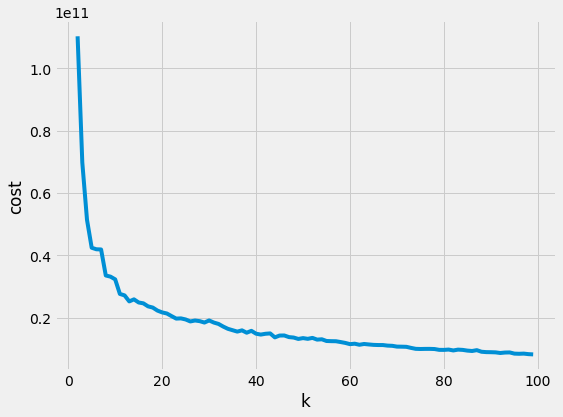

In [46]:
ks = []
scores = []

for k in range(2, 100):
    kmeans = KMeans().setK(k).setSeed(103218823).setFeaturesCol("features") # define k-means model with k clusters
    model = kmeans.fit(transformed) # fit model on our dataset
    
    ks.append(k)
    scores.append(model.computeCost(transformed))

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(ks, scores)
ax.set_xlabel('k')
ax.set_ylabel('cost')

As we can see in the plot, one of the best values for *k* would be 15. Therefore, we will use this value to perform the k-means clustering:

In [51]:
k = 15

kmeans = KMeans().setK(k).setSeed(10388876432723).setFeaturesCol("features")
model = kmeans.fit(transformed)
clustered_hashtags = model.transform(transformed).select('hashtag', 'prediction')

In the end, we want to see in which cluster does the hashtag *brexit* belong:

In [52]:
clustered_hashtags.filter(clustered_hashtags.hashtag == 'brexit').show()

+-------+----------+
|hashtag|prediction|
+-------+----------+
| brexit|        12|
+-------+----------+



Finally, we want to see which are the hashtags who belong to the same cluster as the hashtag *brexit*:

In [53]:
clustered_hashtags.filter(clustered_hashtags.prediction == 12).show(100)

+--------------+----------+
|       hashtag|prediction|
+--------------+----------+
|         euref|        12|
|  eurefresults|        12|
|        brexit|        12|
|dolceamorehhww|        12|
+--------------+----------+



Very interestingly, we can see that the *brexit* hashtag is clustered together with the hashtags *euref* and *eurefresults*, which refer to the EU Referendum, the same event as Brexit. Also, it seems that the referendum took place in the same time with the release of a new episode of *Dolce Amore* TV series, thus all the four hashtags are clustered together.

We can see that the clustering by itself may capture semantics of various hashtags, by exploiting the fact that hashtags with the same usage pattern during time might express the same event. 

In [50]:
sc.stop()